In [15]:
# EDUFACE - Facial Recognition Attendance System
# Integrated with LMS for student attendance recording
# Date: October 25, 2025

# ================================================
# 1. INSTALLING DEPENDENCIES
# ================================================
# Install required packages
!pip install tensorflow opencv-python matplotlib

# ================================================
# 2. IMPORTING DEPENDENCIES
# ================================================
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

# TensorFlow dependencies
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall




[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
# ================================================
# 3. SET GPU MEMORY GROWTH
# ================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Number of GPUs available:", len(gpus))
else:
    print("No GPUs detected. Running on CPU.")


No GPUs detected. Running on CPU.


In [18]:

# ================================================
# 4. SETTING UP FOLDER STRUCTURE
# ================================================
# Define base paths
BASE_PATH = r'C:\Projects\EDUFACE PROJECT'
DATA_PATH = os.path.join(BASE_PATH, 'data')

# Create directories
POS_PATH = os.path.join(DATA_PATH, 'positive')
NEG_PATH = os.path.join(DATA_PATH, 'negative')
ANC_PATH = os.path.join(DATA_PATH, 'anchor')

os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

print(f"✅ Directories created/verified:")
print(f"   Positive: {POS_PATH}")
print(f"   Negative: {NEG_PATH}")
print(f"   Anchor: {ANC_PATH}")



✅ Directories created/verified:
   Positive: C:\Projects\EDUFACE PROJECT\data\positive
   Negative: C:\Projects\EDUFACE PROJECT\data\negative
   Anchor: C:\Projects\EDUFACE PROJECT\data\anchor


In [ ]:
# ================================================
# 5. EXTRACT LFW DATASET FOR NEGATIVES
# ================================================
import tarfile
import glob

# Path to LFW .tgz file
tgz_path = os.path.join(BASE_PATH, 'lfw-funneled.tgz')
extract_path = NEG_PATH

# Validate and extract
if os.path.isfile(tgz_path):
    print(f"Found .tgz file at: {tgz_path}")
    os.makedirs(extract_path, exist_ok=True)
    
    with tarfile.open(tgz_path, 'r:gz') as tar:
        tar.extractall(path=extract_path)
    print("✅ Dataset extracted successfully!")
    
    # Find LFW root
    possible_roots = [
        os.path.join(extract_path, "lfw_funneled"),
        os.path.join(extract_path, "lfw-funneled"),
        os.path.join(extract_path, "lfw"),
    ]
    lfw_root = next((root for root in possible_roots if os.path.exists(root)), None)
    
    if lfw_root:
        print(f"✅ LFW dataset at: {lfw_root}")
        # Move images to negative folder (flatten structure)
        for person_dir in os.listdir(lfw_root):
            person_path = os.path.join(lfw_root, person_dir)
            if os.path.isdir(person_path):
                for img_file in os.listdir(person_path):
                    src = os.path.join(person_path, img_file)
                    dst = os.path.join(NEG_PATH, img_file)
                    if os.path.exists(dst):
                        os.remove(dst)  # Overwrite duplicates
                    os.rename(src, dst)
        # Clean up empty dirs (note: may need to remove lfw_root if empty)
        print("✅ Negatives moved and structure flattened.")
    else:
        print("⚠️ Could not find LFW root. Check extraction.")
else:
    print("⚠️ LFW .tgz not found. Download from http://vis-www.cs.umass.edu/lfw/")




In [ ]:
# ================================================
# 6. COLLECT POSITIVES AND ANCHORS
# ================================================
# Advanced multi-angle face capture with student info
import time
import uuid
import platform

def find_working_webcam(max_index=10):
    backends = [None]
    if platform.system() == "Windows":
        backends.extend([cv2.CAP_DSHOW, cv2.CAP_MSMF])
    elif platform.system() == "Linux":
        backends.append(cv2.CAP_V4L2)
    
    for backend in backends:
        for index in range(max_index):
            cap = cv2.VideoCapture(index, backend) if backend else cv2.VideoCapture(index)
            if cap.isOpened():
                ret, _ = cap.read()
                if ret:
                    return cap, index
                cap.release()
    return None, None

# Get student details
student_name = input("Enter student name: ").strip().replace(" ", "_")
student_id = input("Enter school ID: ").strip().replace('<>:"/\\|?*', '_')

print(f"\n📁 Saving images for {student_name}_{student_id}")
print(f"   Anchor: {ANC_PATH}")
print(f"   Positive: {POS_PATH}")

# Initialize counters
def get_next_count(folder_path, prefix):
    existing = glob.glob(os.path.join(folder_path, f"{prefix}_*.jpg"))
    if existing:
        counts = [int(os.path.basename(f).split('_')[2]) for f in existing if len(os.path.basename(f).split('_')) > 2 and os.path.basename(f).split('_')[2].isdigit()]
        return max(counts) + 1 if counts else 1
    return 1

anchor_count = get_next_count(ANC_PATH, f"{student_name}_{student_id}")
positive_count = get_next_count(POS_PATH, f"{student_name}_{student_id}")

# Load Haar Cascades for multi-angle detection
cascades = {}
cascade_files = {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}

for name, file in cascade_files.items():
    cascade_path = cv2.data.haarcascades + file
    cascade = cv2.CascadeClassifier(cascade_path)
    if not cascade.empty():
        cascades[name] = cascade
        print(f"✅ Loaded {name} cascade")

def detect_faces_multi(gray):
    all_faces = []
    types = []
    for name, cascade in cascades.items():
        scale = 1.1 if 'profile' in name else 1.3
        neighbors = 4 if 'profile' in name else 5
        faces = cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neighbors, minSize=(30, 30))
        for face in faces:
            all_faces.append(face)
            types.append(name)
    return all_faces, types

def remove_overlaps(faces, types, threshold=0.3):
    if len(faces) <= 1:
        return faces, types
    keep = [True] * len(faces)
    for i in range(len(faces)):
        if not keep[i]: continue
        for j in range(i+1, len(faces)):
            if not keep[j]: continue
            # Calculate IoU
            x1, y1, w1, h1 = faces[i]
            x2, y2, w2, h2 = faces[j]
            inter_x = max(0, min(x1+w1, x2+w2) - max(x1, x2))
            inter_y = max(0, min(y1+h1, y2+h2) - max(y1, y2))
            inter = inter_x * inter_y
            union = w1*h1 + w2*h2 - inter
            iou = inter / union if union > 0 else 0
            if iou > threshold:
                # Keep larger face
                if w1*h1 >= w2*h2:
                    keep[j] = False
                else:
                    keep[i] = False
                    break
    return [faces[i] for i in range(len(faces)) if keep[i]], [types[i] for i in range(len(types)) if keep[i]]

# Initialize capture
cap, index = find_working_webcam()
if cap is None:
    raise ValueError("No webcam found.")

capture_type = "positive"
is_capturing = False

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces, face_types = detect_faces_multi(gray)
        faces, face_types = remove_overlaps(faces, face_types)

        colors = {'frontal': (0,255,0), 'profile': (255,0,0), 'frontal_alt': (0,255,255), 'frontal_alt2': (255,0,255)}
        for i, (x,y,w,h) in enumerate(faces):
            ft = face_types[i] if i < len(face_types) else 'frontal'
            color = colors.get(ft, (0,255,0))
            cv2.rectangle(frame, (x,y), (x+w,y+h), color, 2)
            cv2.putText(frame, ft.replace('_',' ').title(), (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        status = f"Mode: {capture_type.upper()} | Faces: {len(faces)} | {'CAPTURING' if is_capturing else 'PAUSED'}"
        cv2.putText(frame, status, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
        count_text = f"Anchor: {anchor_count-1} | Positive: {positive_count-1}"
        cv2.putText(frame, count_text, (10,60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

        cv2.imshow("EDUFACE Capture - 'a' anchor, 'p' positive, 'c' hold to capture, 'q' quit", frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('a'):
            capture_type = 'anchor'
            print("🔄 ANCHOR mode")
        elif key == ord('p'):
            capture_type = 'positive'
            print("🔄 POSITIVE mode")
        elif key == ord('c'):
            is_capturing = not is_capturing  # Toggle
            print(f"{'Start' if is_capturing else 'Stop'} capturing")
        elif key == ord('q'):
            break

        if is_capturing and faces:
            folder = ANC_PATH if capture_type == 'anchor' else POS_PATH
            count = anchor_count if capture_type == 'anchor' else positive_count
            prefix = f"{student_name}_{student_id}"
            
            for i, (x,y,w,h) in enumerate(faces):
                face_crop = frame[y:y+h, x:x+w]
                ft = face_types[i] if i < len(face_types) else 'frontal'
                angle = ft.replace('frontal','front').replace('_alt','').replace('_alt2','')
                unique_id = str(uuid.uuid4())[:8]
                filename = os.path.join(folder, f"{prefix}_{angle}_{count}_{unique_id}.jpg")
                resized = cv2.resize(face_crop, (250, 250))  # Capture at 250x250
                cv2.imwrite(filename, resized)
                print(f"✅ Saved {os.path.basename(filename)} ({ft}, {capture_type})")
                
                if capture_type == 'anchor':
                    anchor_count += 1
                else:
                    positive_count += 1
            
            time.sleep(0.2)  # Rate limit

finally:
    cap.release()
    cv2.destroyAllWindows()

# Dataset summary
total_anchor = len(glob.glob(os.path.join(ANC_PATH, "*.jpg")))
total_positive = len(glob.glob(os.path.join(POS_PATH, "*.jpg")))
total_negative = len(glob.glob(os.path.join(NEG_PATH, "*.jpg")))

print(f"\n📊 Dataset Summary:")
print(f"   Anchor: {total_anchor}")
print(f"   Positive: {total_positive}")
print(f"   Negative: {total_negative}")

if total_anchor < 10 or total_positive < 10:
    print("⚠️ WARNING: Collect more images (10+ per class) for better performance.")


Raw counts: Anchor=1482, Positive=1457, Negative=13966
Valid students with sufficient data: 375 (['Benjamin_151541_151541_front2_129', 'Benjamin_151541_151541_front2_144', 'Benjamin_151541_151541_front2_194', 'Benjamin_151541_151541_front2_195', 'Benjamin_151541_151541_front2_197', 'Benjamin_151541_151541_front2_73', 'Benjamin_151541_151541_front2_75', 'Benjamin_151541_151541_front2_86', 'Benjamin_151541_151541_front2_91', 'Benjamin_151541_151541_front_100', 'Benjamin_151541_151541_front_102', 'Benjamin_151541_151541_front_112', 'Benjamin_151541_151541_front_113', 'Benjamin_151541_151541_front_114', 'Benjamin_151541_151541_front_115', 'Benjamin_151541_151541_front_117', 'Benjamin_151541_151541_front_118', 'Benjamin_151541_151541_front_119', 'Benjamin_151541_151541_front_146', 'Benjamin_151541_151541_front_151', 'Benjamin_151541_151541_front_162', 'Benjamin_151541_151541_front_168', 'Benjamin_151541_151541_front_170', 'Benjamin_151541_151541_front_173', 'Benjamin_151541_151541_front_175

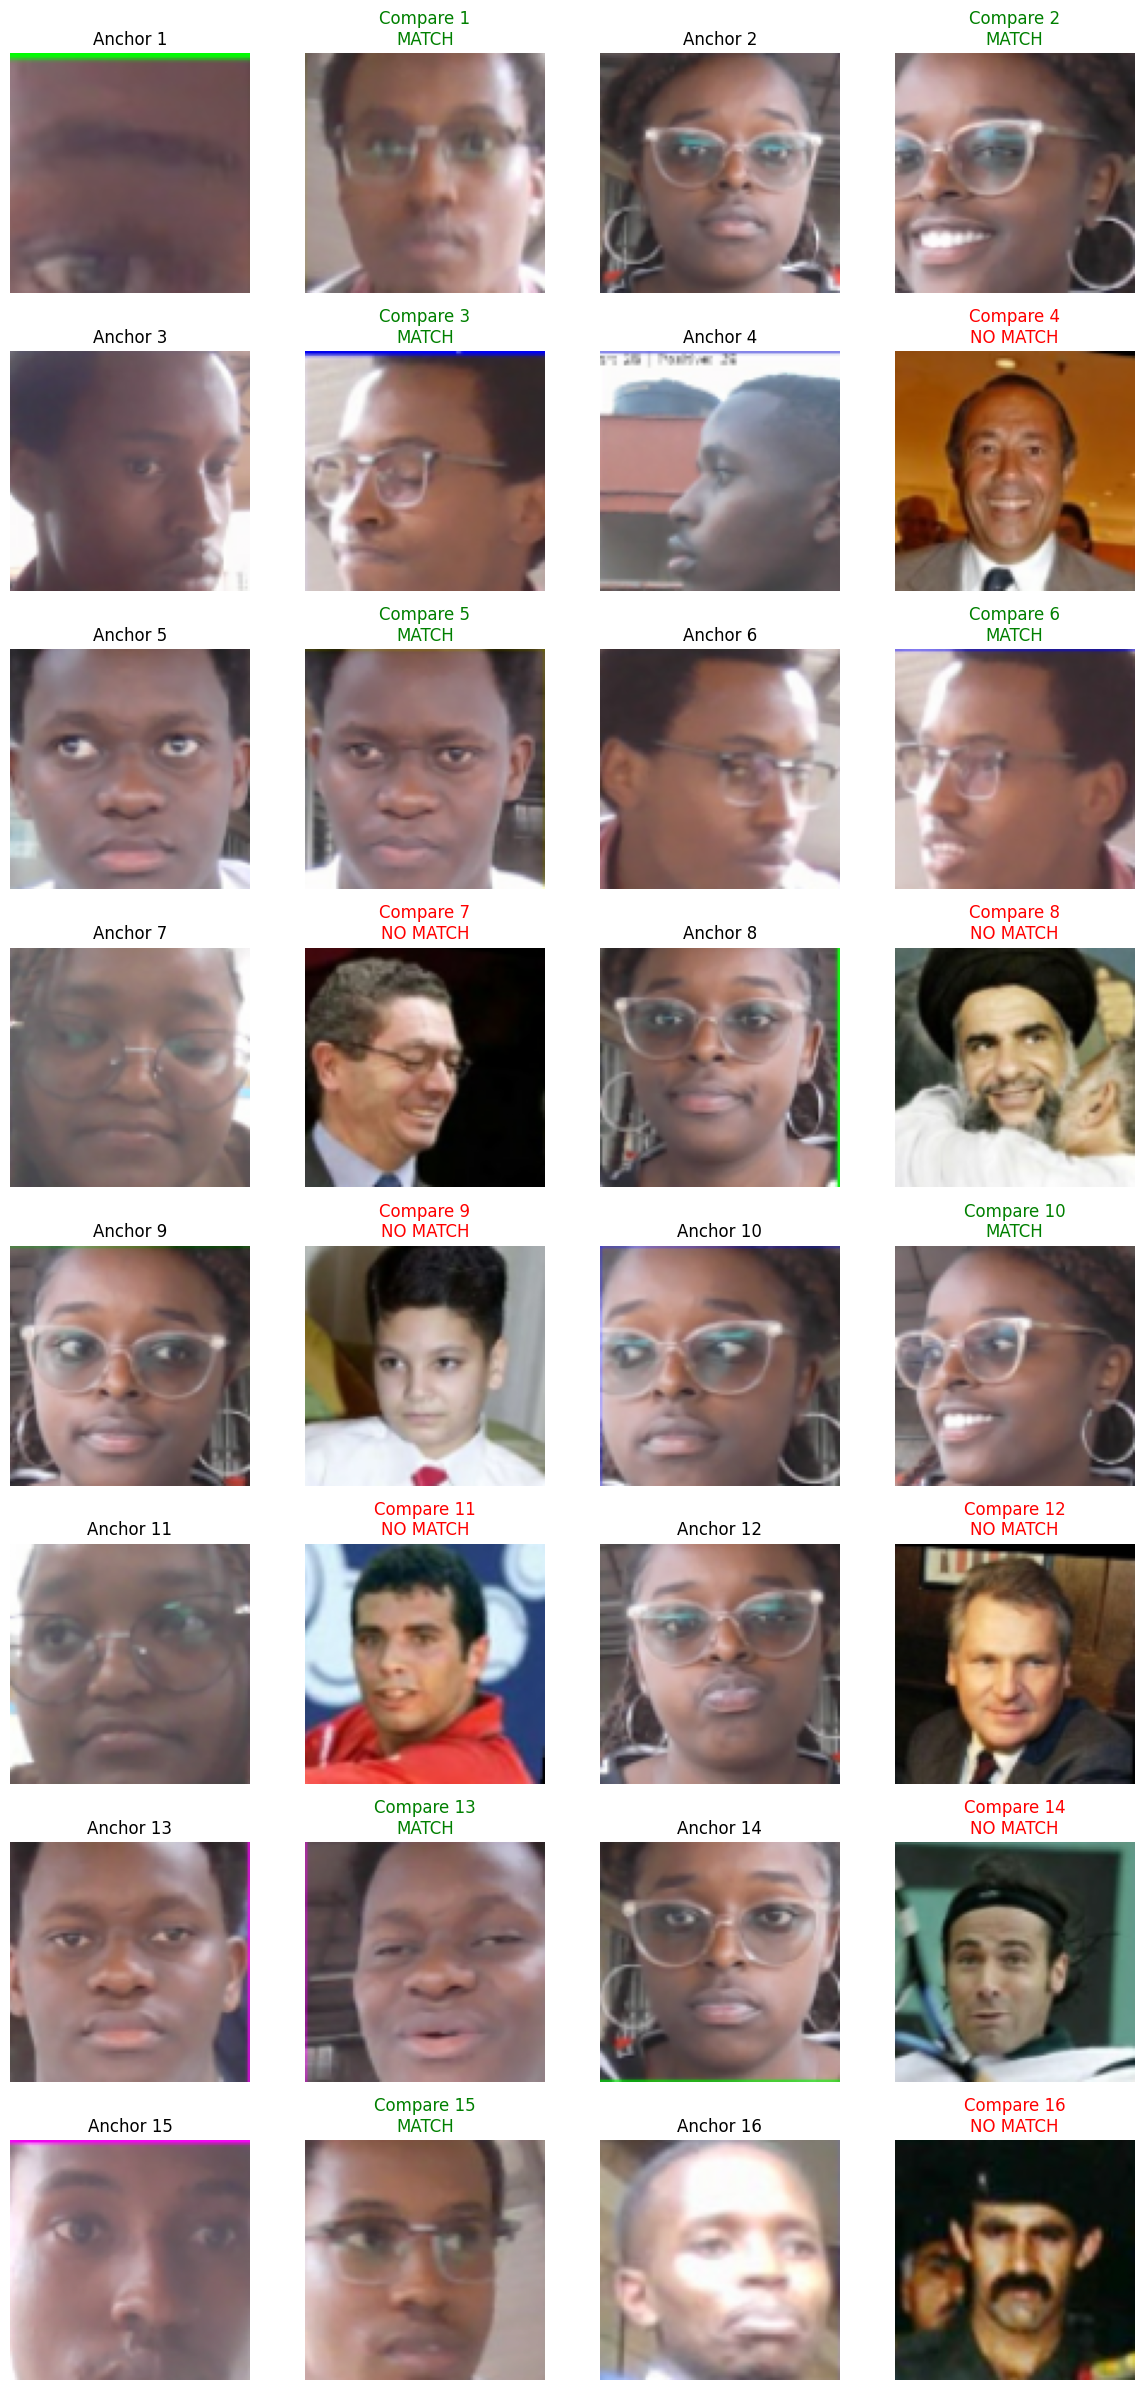

In [19]:
# ================================================
# 7. LOAD AND PREPROCESS IMAGES (FIXED: PER-STUDENT PAIRING)
# ================================================
import glob
import re  # For prefix extraction

# Define preprocess function for single image
def preprocess(file_path):
    # Convert tensor to string if needed (ensures compatibility)
    file_path = tf.strings.as_string(file_path)
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    img = tf.image.resize(img, (100, 100))
    img = tf.image.random_crop(img, [90, 90, 3])
    img = tf.image.resize(img, (100, 100))  # Resize back to model input size
    img = tf.image.random_flip_left_right(img)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Define preprocess_twin for pairs
def preprocess_twin(anchor_path, positive_path, label):
    anchor_img = preprocess(anchor_path)
    positive_img = preprocess(positive_path)
    return (anchor_img, positive_img, label)

# Get all image paths (recursive if needed)
all_anchor_files = glob.glob(os.path.join(ANC_PATH, '*.jpg'))
all_positive_files = glob.glob(os.path.join(POS_PATH, '*.jpg'))
all_negative_files = glob.glob(os.path.join(NEG_PATH, '*.jpg'))

print(f"Raw counts: Anchor={len(all_anchor_files)}, Positive={len(all_positive_files)}, Negative={len(all_negative_files)}")

# Extract student prefixes (e.g., 'nellius_123' from filename)
def get_student_prefix(filename):
    basename = os.path.basename(filename)
    # Match pattern: name_id_angle_count_uuid.jpg → extract name_id
    match = re.match(r'([a-zA-Z0-9_]+_[a-zA-Z0-9-]+)_.*\.jpg', basename)
    return match.group(1) if match else 'unknown'

# Group by student
anchor_by_student = {}
positive_by_student = {}
for f in all_anchor_files:
    prefix = get_student_prefix(f)
    if prefix not in anchor_by_student:
        anchor_by_student[prefix] = []
    anchor_by_student[prefix].append(f)

for f in all_positive_files:
    prefix = get_student_prefix(f)
    if prefix not in positive_by_student:
        positive_by_student[prefix] = []
    positive_by_student[prefix].append(f)

# Filter to students with BOTH anchors & positives (min 1 each for demo)
valid_students = [s for s in anchor_by_student if s in positive_by_student and 
                  len(anchor_by_student[s]) >= 1 and len(positive_by_student[s]) >= 1]
print(f"Valid students with sufficient data: {len(valid_students)} ({valid_students})")

# Build paired datasets PER STUDENT (no cross-mixing!)
anchor_paths = []
positive_paths = []
labels = []

for student in valid_students:
    student_anchors = sorted(anchor_by_student[student])  # Sort for consistent pairing
    student_positives = sorted(positive_by_student[student])
    min_per_student = min(len(student_anchors), len(student_positives))
    
    # Pair sequentially: anchor[0] with positive[0], etc. (same session/person)
    for i in range(min_per_student):
        anchor_paths.append(student_anchors[i])
        positive_paths.append(student_positives[i])
        labels.append(1.0)  # True match for this person

# For negatives: Random from ALL (different people), same count as positives
num_pos_pairs = len(anchor_paths)
negative_paths = sorted(all_negative_files)  # Flat LFW
if len(negative_paths) > num_pos_pairs:
    negative_paths = negative_paths[:num_pos_pairs]  # Balance

# Create TF datasets (no shuffle here—pairing is fixed!)
anchor = tf.data.Dataset.from_tensor_slices(anchor_paths)
positive = tf.data.Dataset.from_tensor_slices(positive_paths)
negative = tf.data.Dataset.from_tensor_slices(negative_paths)

# Positives: Zip same-student pairs
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(num_pos_pairs))))

# Negatives: Zip anchors with random negatives (label 0)
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(num_pos_pairs))))

# Combine
data = positives.concatenate(negatives)
print(f"✅ Fixed pairs: {num_pos_pairs} per-student matches + {min(num_pos_pairs, len(negative_paths))} negatives = {tf.data.experimental.cardinality(data).numpy()} total")

# Rest of pipeline (augment AFTER pairing to preserve mappings)
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(1024)  # Shuffle whole dataset now (safe post-pairing)
data = data.batch(16)
data = data.prefetch(8)

print(f"✅ Pipeline ready: {num_pos_pairs * 2} samples, batch size 16")

# Visualize sample batch
try:
    samples = data.as_numpy_iterator()
    batch = next(samples)
    n_samples = batch[0].shape[0]
    if n_samples > 0:
        num_rows = (n_samples + 1) // 2
        fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3 * num_rows))
        if num_rows > 1:
            axes = axes.reshape(num_rows, -1)
        else:
            axes = axes.reshape(1, -1)
        for i in range(n_samples):
            row = i // 2
            col1 = (i % 2) * 2
            col2 = col1 + 1
            axes[row, col1].imshow(batch[0][i])
            axes[row, col1].set_title(f"Anchor {i+1}")
            axes[row, col1].axis('off')
            
            axes[row, col2].imshow(batch[1][i])
            label = "MATCH" if batch[2][i] == 1 else "NO MATCH"
            color = 'green' if batch[2][i] == 1 else 'red'
            axes[row, col2].set_title(f"Compare {i+1}\n{label}", color=color)
            axes[row, col2].axis('off')
        
        # Hide extra subplots if any
        for i in range(n_samples, num_rows * 2):
            row = i // 2
            col1 = (i % 2) * 2
            col2 = col1 + 1
            axes[row, col1].axis('off')
            axes[row, col2].axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Empty batch, no visualization.")
except StopIteration:
    print("No data available for visualization.")


In [20]:

# ================================================
# 8. SPLIT DATA INTO TRAIN/VAL/TEST
# ================================================
total_batches = tf.data.experimental.cardinality(data).numpy()
train_size = int(0.7 * total_batches)
val_size = int(0.15 * total_batches)
test_size = total_batches - train_size - val_size

train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size)

print(f"Split: Train={train_size} batches, Val={val_size}, Test={test_size}")



Split: Train=32 batches, Val=7, Test=8


In [ ]:
# ================================================
# 9. MODEL ENGINEERING
# ================================================
# Build Embedding Model - FIXED: Remove lists from inputs/outputs for single I/O
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D((2,2), padding='same')(c1)
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D((2,2), padding='same')(c2)
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D((2,2), padding='same')(c3)
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    return Model(inputs=inp, outputs=d1, name='embedding')

embedding = make_embedding()
embedding.summary()

# L1 Distance Layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Siamese Model
def make_siamese_model():
    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))
    siamese_layer = L1Dist(name='distance')
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()
siamese_model.summary()



In [ ]:
# ================================================
# 10. TRAINING SETUP
# ================================================
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

# Checkpoints
checkpoint_dir = os.path.join(BASE_PATH, 'training_checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

# Train Step
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    gradients = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))
    return loss

# Training Loop with History
def train(data, val_data, EPOCHS):
    history = {'loss': [], 'val_loss': []}
    for epoch in range(1, EPOCHS+1):
        print(f'\n📅 Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        
        epoch_loss = 0.0
        num_train_batches = 0
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            epoch_loss += loss
            num_train_batches += 1
            progbar.update(idx + 1)
        
        if num_train_batches > 0:
            avg_loss = epoch_loss / num_train_batches
        else:
            avg_loss = 0.0
        history['loss'].append(avg_loss.numpy())
        
        # Validation loss
        val_loss = 0.0
        num_val_batches = 0
        for batch in val_data:
            X = batch[:2]
            y = batch[2]
            yhat = siamese_model(X, training=False)
            val_loss += binary_cross_loss(y, yhat)
            num_val_batches += 1
        if num_val_batches > 0:
            avg_val_loss = val_loss / num_val_batches
        else:
            avg_val_loss = 0.0
        history['val_loss'].append(avg_val_loss.numpy())
        print(f"Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"💾 Checkpoint saved at epoch {epoch}")
    
    return history


In [ ]:

# Train
EPOCHS = 50  # Reduced for demo; increase as needed
print("🚀 Starting training...")
history = train(train_data, val_data, EPOCHS)
print("✅ Training complete!")

# Plot History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')

plt.subplot(1, 2, 2)
# Note: Accuracy not tracked; add if needed
plt.plot(history['loss'], label='Training Loss (proxy for acc)')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Performance')

plt.tight_layout()
plt.show()



In [14]:
# ================================================
# 11. EVALUATE MODEL
# ================================================
# Test on one batch
try:
    test_batch = test_data.as_numpy_iterator().next()
    test_input, test_val, y_true = test_batch
    y_hat = siamese_model.predict([test_input, test_val])

    # Threshold predictions
    res = [1 if pred[0] > 0.5 else 0 for pred in y_hat]

    print(f"Predictions: Matches={sum(res)}/{len(res)}, True matches={int(sum(y_true))}")

    # Metrics
    recall = Recall()
    recall.update_state(y_true, tf.cast(res, tf.float32))
    precision = Precision()
    precision.update_state(y_true, tf.cast(res, tf.float32))

    print(f"\n📊 Metrics on Test Batch:")
    print(f"   Precision: {precision.result().numpy():.4f}")
    print(f"   Recall: {recall.result().numpy():.4f}")

    # Confusion Matrix
    tp = sum(1 for i in range(len(y_true)) if y_true[i] == 1 and res[i] == 1)
    fp = sum(1 for i in range(len(y_true)) if y_true[i] == 0 and res[i] == 1)
    tn = sum(1 for i in range(len(y_true)) if y_true[i] == 0 and res[i] == 0)
    fn = sum(1 for i in range(len(y_true)) if y_true[i] == 1 and res[i] == 0)

    print(f"   TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    accuracy = (tp + tn) / len(y_true)
    print(f"   Accuracy: {accuracy:.4f}")

    # Visualize Predictions
    n_vis = min(8, len(test_input))
    plt.figure(figsize=(15, 5 * ((n_vis + 1) // 2)))
    for i in range(n_vis):
        plt.subplot((n_vis + 1) // 2, 4, 2 * i + 1)
        plt.imshow(test_input[i])
        plt.title(f"Anchor {i+1}")
        plt.axis('off')
        
        plt.subplot((n_vis + 1) // 2, 4, 2 * i + 2)
        plt.imshow(test_val[i])
        pred = "MATCH" if res[i] == 1 else "NO MATCH"
        true = "MATCH" if y_true[i] == 1 else "NO MATCH"
        correct = "✅" if res[i] == y_true[i] else "❌"
        color = 'green' if res[i] == y_true[i] else 'red'
        plt.title(f"Compare {i+1}\nPred: {pred}\nTrue: {true} {correct}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
except StopIteration:
    print("No test data available for evaluation.")



NameError: name 'test_data' is not defined

In [ ]:
# ================================================
# 12. SAVE MODEL
# ================================================
model_path = os.path.join(BASE_PATH, 'siamese_model.h5')
siamese_model.save(model_path)
print(f"✅ Model saved to {model_path}")

In [13]:

# Load test
loaded_model = tf.keras.models.load_model(model_path, custom_objects={'L1Dist': L1Dist})
print("✅ Model loaded successfully.")

print("🎉 EDUFACE system ready for LMS integration!")

✅ Model loaded successfully.
🎉 EDUFACE system ready for LMS integration!


In [ ]:

# ================================================
# 13. REAL-TIME VERIFICATION (FOR LMS INTEGRATION)
# ================================================
# Create verification images folder if needed
VERIFICATION_PATH = os.path.join(BASE_PATH, 'verification_images')
os.makedirs(VERIFICATION_PATH, exist_ok=True)
INPUT_PATH = os.path.join(BASE_PATH, 'input_image')
os.makedirs(INPUT_PATH, exist_ok=True)

def preprocess_py(path):
    """Python version of preprocess for non-tensor inputs"""
    byte_img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    img = tf.image.resize(img, (100, 100))
    img = tf.image.random_crop(img, [90, 90, 3])
    img = tf.image.resize(img, (100, 100))  # Resize back to model input size
    img = tf.image.random_flip_left_right(img)
    img = tf.cast(img, tf.float32) / 255.0
    return img.numpy()

def verify(model, detection_threshold=0.5, verification_threshold=0.7):
    verification_images = os.listdir(VERIFICATION_PATH)
    if not verification_images:
        print("No verification images found.")
        return [], False
    
    results = []
    for image in verification_images:
        input_img = preprocess_py(os.path.join(INPUT_PATH, 'input_image.jpg'))
        val_img = preprocess_py(os.path.join(VERIFICATION_PATH, image))
        result = model.predict(np.expand_dims([input_img, val_img], axis=0))[0][0]
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(verification_images)
    verified = verification > verification_threshold
    return results, verified

# Real-time verification
cap = cv2.VideoCapture(0)  # Use default camera
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Crop to face region (adjust as needed)
    frame = frame[120:370, 200:450, :]  # 250x250 crop
    
    cv2.imshow('EDUFACE Verification - Press V to verify, Q to quit', frame)
    
    key = cv2.waitKey(10) & 0xFF
    if key == ord('v'):
        cv2.imwrite(os.path.join(INPUT_PATH, 'input_image.jpg'), frame)
        results, verified = verify(loaded_model)
        status = "VERIFIED ✅" if verified else "NOT VERIFIED ❌"
        confidence = np.mean(results) if results else 0.0
        print(f"{status} (Confidence: {confidence:.2f})")
        # Here: Integrate with LMS - e.g., log attendance for student_id
        print(f"Logging attendance for {student_id}...")
    elif key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
Training Loss: ['0.5652', '0.2758', '0.2152', '0.1424', '0.0982', '0.0755', '0.0701', '0.0513', '0.0315', '0.0199', '0.0097', '0.0094', '0.0027', '0.0018', '0.0014', '0.0011', '0.0008', '0.0008', '0.0007', '0.0007', '0.0005', '0.0005', '0.0004', '0.0004', '0.0003', '0.0004', '0.0002', '0.0003', '0.0003', '0.0002', '0.0002', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0000', '0.0001', '0.0001', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']
Validation Loss: ['0.2777', '0.2686', '0.1898', '0.1082', '0.0740', '0.0395', '0.0416', '0.0224', '0.0157', '0.0091', '0.0069', '0.0020', '0.0025', '0.0015', '0.0004', '0.0014', '0.0011', '0.0017', '0.0005', '0.0002', '0.0007', '0.0010', '0.0005', '0.0004', '0.0004', '0.0002', '0.000

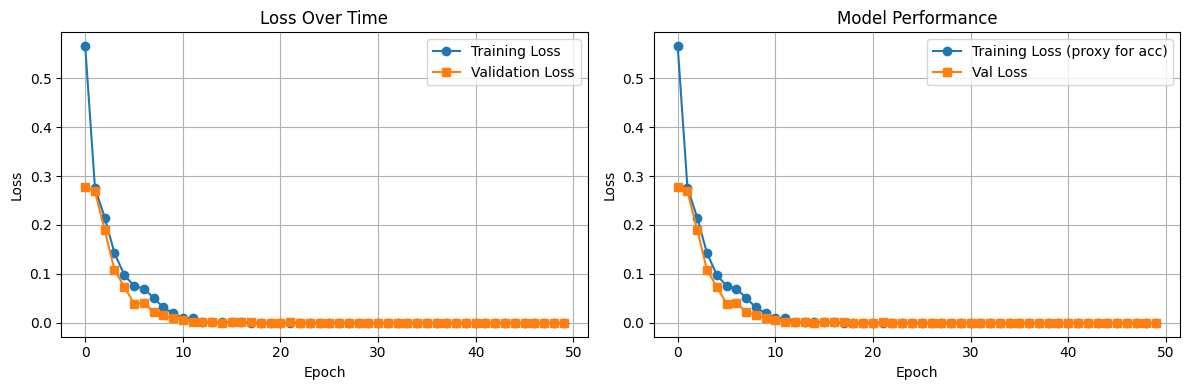


✅ Plot saved as 'training_loss_plot.png'. Share the printed values or describe the plot trends!


In [17]:
# Code to extract and print the training history data for the loss plot
# Run this after your training (where 'history' is defined from train() function)

import matplotlib.pyplot as plt
import numpy as np

# Print numerical values (easy to copy-paste)
print("Epochs:", list(range(1, len(history['loss']) + 1)))
print("Training Loss:", [f"{loss:.4f}" for loss in history['loss']])
print("Validation Loss:", [f"{val:.4f}" for val in history['val_loss']])

# Optionally, regenerate and save the plot as PNG (if you have the env)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss (proxy for acc)', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Performance')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_loss_plot.png', dpi=150, bbox_inches='tight')  # Saves to current dir
plt.show()

print("\n✅ Plot saved as 'training_loss_plot.png'. Share the printed values or describe the plot trends!")

In [11]:

import cv2
import os
import uuid
import time
import platform
import numpy as np
import re  # For prefix extraction

# Setup paths
BASE_PATH = r'C:\Projects\EDUFACE PROJECT'
VERIFICATION_PATH = os.path.join(BASE_PATH, 'verification_images')
os.makedirs(VERIFICATION_PATH, exist_ok=True)

# Helper: Get student groups and counts (same as verification)
def get_student_counts(path):
    images = [f for f in os.listdir(path) if f.lower().endswith('.jpg')]
    groups = {}
    messy_files = []  # Flag bad filenames
    for img in images:
        match = re.match(r'([a-zA-Z0-9_]+_[a-zA-Z0-9-]+)_.*\.jpg', img)
        if match:
            prefix = match.group(1)
            groups.setdefault(prefix, []).append(img)
        else:
            messy_files.append(img)
    counts = {prefix: len(imgs) for prefix, imgs in groups.items()}
    max_count = max(counts.values()) if counts else 0
    return counts, max_count, messy_files

# Pre-scan for balance
counts, max_count, messy = get_student_counts(VERIFICATION_PATH)
if messy:
    print(f"⚠️ Warning: {len(messy)} messy filenames detected (e.g., no '_angle_'). Run rename script first!")
if counts:
    print(f"📊 Current students: {', '.join(f'{k}: {v}' for k, v in counts.items())}")
    suggested = max_count  # Or max_count + 5 for buffer
    print(f"💡 Suggested target: {suggested} (matches max for balance)")
else:
    suggested = 10
    print("💡 No students yet—starting with 10.")

# Get student details
student_name = input("Enter new student name: ").strip().replace(" ", "_")
student_id = input("Enter school ID: ").strip().replace('<>:"/\\|?*', '_')
target_input = input(f"How many images to capture? (Suggested: {suggested}, Recommended: 10-20, mix front/sides): ") or str(suggested)
target_images = int(target_input)

# Check existing for this student
prefix = f"{student_name}_{student_id}"
existing_count = counts.get(prefix, 0)
to_capture = max(0, target_images - existing_count)
if existing_count > 0:
    print(f"🔄 Re-enrolling {prefix}: {existing_count} existing → capturing {to_capture} more (total {target_images}).")
else:
    print(f"\n📁 Enrolling new {prefix} - Saving to {VERIFICATION_PATH}")
    to_capture = target_images
print("🎥 Tips: Start frontal, then turn head left/right for profiles (sides/chin). Green=Front, Blue=Profile.")

# Find working webcam
def find_working_webcam(max_index=10):
    backends = [None]
    if platform.system() == "Windows":
        backends.extend([cv2.CAP_DSHOW, cv2.CAP_MSMF])
    elif platform.system() == "Linux":
        backends.append(cv2.CAP_V4L2)
    
    for backend in backends:
        for index in range(max_index):
            cap = cv2.VideoCapture(index, backend) if backend else cv2.VideoCapture(index)
            if cap.isOpened():
                ret, _ = cap.read()
                if ret:
                    return cap, index
                cap.release()
    return None, None

cap, index = find_working_webcam()
if cap is None:
    raise ValueError("No webcam found!")

# Load multiple Haar Cascades for full coverage
cascades = {}
cascade_files = {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}
for name, file in cascade_files.items():
    cascade_path = cv2.data.haarcascades + file
    cascade = cv2.CascadeClassifier(cascade_path)
    if not cascade.empty():
        cascades[name] = cascade
        print(f"✅ Loaded {name} cascade")

def detect_faces_multi(gray):
    all_faces = []
    types = []
    for name, cascade in cascades.items():
        scale = 1.1 if 'profile' in name else 1.3
        neighbors = 4 if 'profile' in name else 5
        faces = cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neighbors, minSize=(30, 30))
        for face in faces:
            all_faces.append(face)
            types.append(name)
    return all_faces, types

def remove_overlaps(faces, types, threshold=0.3):
    if len(faces) <= 1:
        return faces, types
    keep = [True] * len(faces)
    for i in range(len(faces)):
        if not keep[i]: continue
        for j in range(i+1, len(faces)):
            if not keep[j]: continue
            x1, y1, w1, h1 = faces[i]
            x2, y2, w2, h2 = faces[j]
            inter_x = max(0, min(x1+w1, x2+w2) - max(x1, x2))
            inter_y = max(0, min(y1+h1, y2+h2) - max(y1, y2))
            inter = inter_x * inter_y
            union = w1*h1 + w2*h2 - inter
            iou = inter / union if union > 0 else 0
            if iou > threshold:
                if w1*h1 >= w2*h2:
                    keep[j] = False
                else:
                    keep[i] = False
                    break
    return [faces[i] for i in range(len(faces)) if keep[i]], [types[i] for i in range(len(types)) if keep[i]]

captured = 0
is_capturing = False
total_target = to_capture  # For display

try:
    while captured < to_capture:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces, face_types = detect_faces_multi(gray)
        faces, face_types = remove_overlaps(faces, face_types)

        # Draw rectangles if faces detected
        colors = {'frontal': (0,255,0), 'profile': (255,0,0), 'frontal_alt': (0,255,255), 'frontal_alt2': (255,0,255)}
        num_faces = len(faces)
        for i, (x, y, w, h) in enumerate(faces):
            ft = face_types[i] if i < len(face_types) else 'frontal'
            color = colors.get(ft, (0,255,0)) if num_faces == 1 else (0,0,255)  # Red if multiple
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, ft.replace('_',' ').title(), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        cv2.putText(frame, f"Captured: {captured}/{total_target} (Total goal: {target_images}) | Turn for profiles!", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

        status = "CAPTURING (Space to toggle) | Press 'Q' to quit" if is_capturing else "PAUSED - Press Space to start"
        cv2.putText(frame, status, (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        cv2.imshow(f"EDUFACE Enrollment - {student_name}_{student_id}", frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord(' '):  # Space to toggle capture
            is_capturing = not is_capturing
            print(f"{'Started' if is_capturing else 'Stopped'} capturing")
        elif key == ord('q'):
            break

        # Auto-capture if face detected and capturing mode on
        if is_capturing and num_faces == 1 and captured < to_capture:
            (x, y, w, h) = faces[0]
            face_crop = frame[y:y+h, x:x+w]
            resized = cv2.resize(face_crop, (250, 250))
            
            unique_id = str(uuid.uuid4())[:8]
            ft = face_types[0] if len(face_types) > 0 else 'frontal'
            filename = f"{student_name}_{student_id}_{ft}_{existing_count + captured + 1}_{unique_id}.jpg"  # Sequential num
            filepath = os.path.join(VERIFICATION_PATH, filename)
            cv2.imwrite(filepath, resized)
            print(f"✅ Enrolled {ft} image {existing_count + captured + 1}/{target_images}: {filename}")
            
            captured += 1
            time.sleep(1)  # Pause for variation

finally:
    cap.release()
    cv2.destroyAllWindows()

print(f"\n🎉 Enrollment complete! {captured} new images added (total for {prefix}: {existing_count + captured}).")
print("💡 Re-run group-check code to verify balance. Now test PART 2 verification!")

📊 Current students: Fancy_150828_frontal_alt2_10: 1, Fancy_150828_frontal_alt2_1: 1, Fancy_150828_frontal_alt2_2: 1, Fancy_150828_frontal_alt2_3: 1, Fancy_150828_frontal_alt2_4: 1, Fancy_150828_frontal_alt2_6: 1, Fancy_150828_frontal_alt2_7: 1, Fancy_150828_frontal_alt2_9: 1, Fancy_150828_frontal_alt_5: 1, Fancy_150828_frontal_alt_8: 1, Fancy_150828_profile_11: 1, Fancy_150828_profile_12: 1, Fancy_150828_profile_13: 1, Fancy_150828_profile_14: 1, Fancy_150828_profile_15: 1, George_150909_profile_11: 1, George_150909_profile_14: 1, George_150909_profile_15: 1, George_150909_profile_2: 1, George_150909_profile_4: 1, George_150909_profile_5: 2, George_150909_profile_6: 2, George_150909_profile_7: 2, Mark_151430_frontal_10: 1, Mark_151430_frontal_8: 1, Mark_151430_frontal_alt2_11: 1, Mark_151430_frontal_alt2_13: 1, Mark_151430_frontal_alt2_1: 1, Mark_151430_frontal_alt2_3: 1, Mark_151430_frontal_alt2_4: 1, Mark_151430_frontal_alt2_7: 1, Mark_151430_frontal_alt2_9: 1, Mark_151430_frontal_al

In [12]:
# ================================================
# PART 2: DAILY ATTENDANCE VERIFICATION (AUTO-MAPPING - FACE SCAN & IDENTIFY)
# ================================================
# Enhanced: Auto-scans face on 'V', then maps to best-matching student (no manual ID input)
# Groups enrolled images by student prefix; verifies against all for identification
# Only proceeds if single face detected. Real-time live verification.
# Assumes flat verification_images with filenames like {name_id}_{type}_{num}_{uuid}.jpg
# Requires: TensorFlow, OpenCV (pip install tensorflow opencv-python)

import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from datetime import datetime
import re  # For student prefix extraction

# Define custom layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Setup paths
BASE_PATH = r'C:\Projects\EDUFACE PROJECT'
VERIFICATION_PATH = os.path.join(BASE_PATH, 'verification_images')
INPUT_PATH = os.path.join(BASE_PATH, 'input_image')
os.makedirs(INPUT_PATH, exist_ok=True)

# Load model
model_path = os.path.join(BASE_PATH, 'siamese_model.h5')
loaded_model = load_model(model_path, custom_objects={'L1Dist': L1Dist})
print("✅ Model loaded.")

# Load Haar Cascades for face detection
cascades = {}
cascade_files = {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}
for name, file in cascade_files.items():
    cascade_path = cv2.data.haarcascades + file
    cascade = cv2.CascadeClassifier(cascade_path)
    if not cascade.empty():
        cascades[name] = cascade
        print(f"✅ Loaded {name} cascade")

def detect_faces_multi(gray):
    all_faces = []
    types = []
    for name, cascade in cascades.items():
        scale = 1.1 if 'profile' in name else 1.3
        neighbors = 4 if 'profile' in name else 5
        faces = cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neighbors, minSize=(30, 30))
        for face in faces:
            all_faces.append(face)
            types.append(name)
    return all_faces, types

def remove_overlaps(faces, types, threshold=0.3):
    if len(faces) <= 1:
        return faces, types
    keep = [True] * len(faces)
    for i in range(len(faces)):
        if not keep[i]: continue
        for j in range(i+1, len(faces)):
            if not keep[j]: continue
            x1, y1, w1, h1 = faces[i]
            x2, y2, w2, h2 = faces[j]
            inter_x = max(0, min(x1+w1, x2+w2) - max(x1, x2))
            inter_y = max(0, min(y1+h1, y2+h2) - max(y1, y2))
            inter = inter_x * inter_y
            union = w1*h1 + w2*h2 - inter
            iou = inter / union if union > 0 else 0
            if iou > threshold:
                if w1*h1 >= w2*h2:
                    keep[j] = False
                else:
                    keep[i] = False
                    break
    return [faces[i] for i in range(len(faces)) if keep[i]], [types[i] for i in range(len(types)) if keep[i]]

# Preprocess function
def preprocess_py(path):
    byte_img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    img = tf.image.resize(img, (100, 100))
    img = tf.image.random_crop(img, [90, 90, 3])
    img = tf.image.resize(img, (100, 100))
    img = tf.image.random_flip_left_right(img)
    img = tf.cast(img, tf.float32) / 255.0
    return img.numpy()

# Updated verify: Auto-maps by grouping images per student, finds best match
def verify(model, detection_threshold=0.6, verification_threshold=0.8):
    verification_images = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')]
    if not verification_images:
        print("⚠️ No enrolled images found!")
        return None, [], False
    
    input_img_path = os.path.join(INPUT_PATH, 'input_image.jpg')
    if not os.path.exists(input_img_path):
        return None, [], False
    
    input_img = preprocess_py(input_img_path)
    
    # Extract student prefixes (e.g., 'nellius_123' from 'nellius_123_frontal_1_uuid.jpg')
    def get_student_prefix(filename):
        match = re.match(r'([a-zA-Z0-9_]+_[a-zA-Z0-9-]+)_.*\.jpg', filename)
        return match.group(1) if match else 'unknown'
    
    # Group images by student
    student_groups = {}
    for image in verification_images:
        prefix = get_student_prefix(image)
        if prefix not in student_groups:
            student_groups[prefix] = []
        student_groups[prefix].append(image)
    
    if not student_groups:
        print("⚠️ No valid student groups found!")
        return None, [], False
    
    # Compute avg scores per student
    student_scores = {}
    all_results = []
    for student_id, images in student_groups.items():
        results = []
        for image in images:
            val_img_path = os.path.join(VERIFICATION_PATH, image)
            val_img = preprocess_py(val_img_path)
            batched_input = np.expand_dims(input_img, axis=0)
            batched_val = np.expand_dims(val_img, axis=0)
            result = model.predict([batched_input, batched_val], verbose=0)[0][0]
            results.append(result)
            all_results.append(result)
        if results:
            avg_score = np.mean(results)
            student_scores[student_id] = avg_score
            print(f"  {student_id}: Avg {avg_score:.2f} (from {len(images)} images)")
    
    if not student_scores:
        return None, [], False
    
    # Find best-matching student (highest avg > threshold)
    best_student = max(student_scores, key=student_scores.get)
    best_score = student_scores[best_student]
    
    # Check if best is above threshold (e.g., >80% match rate implied by avg)
    verified = best_score > verification_threshold
    if verified:
        print(f"🔍 Mapped to student: {best_student} (Best Confidence: {best_score:.2f})")
        return best_student, all_results, verified
    else:
        print(f"❌ No strong match. Closest: {best_student} ({best_score:.2f})")
        return None, all_results, False

# Live verification loop (no manual ID input)
print("🔍 Auto-identification mode: Scan face to map to enrolled student.")

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise ValueError("No webcam.")

print("🎥 Position face clearly. Green box = detected. Press 'V' to scan & map, 'Q' to quit.")

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces, face_types = detect_faces_multi(gray)
        faces, face_types = remove_overlaps(faces, face_types)
        
        # Draw detections
        colors = {'frontal': (0,255,0), 'profile': (255,0,0), 'frontal_alt': (0,255,255), 'frontal_alt2': (255,0,255)}
        num_faces = len(faces)
        for i, (x,y,w,h) in enumerate(faces):
            ft = face_types[i] if i < len(face_types) else 'frontal'
            color = colors.get(ft, (0,255,0)) if num_faces == 1 else (0,0,255)  # Red if multiple
            cv2.rectangle(frame, (x,y), (x+w,y+h), color, 2)
            cv2.putText(frame, ft.replace('_',' ').title(), (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        status = f"Auto-Map Mode | Faces: {num_faces} | Press 'V' (if 1 face) to scan"
        cv2.putText(frame, status, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        cv2.imshow('EDUFACE Daily Attendance', frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('v'):
            if num_faces == 1:
                (x, y, w, h) = faces[0]
                face_crop = frame[y:y+h, x:x+w]
                resized_crop = cv2.resize(face_crop, (250, 250))
                cv2.imwrite(os.path.join(INPUT_PATH, 'input_image.jpg'), resized_crop)
                print("📸 Face scanned.")
                
                best_student, results, verified = verify(loaded_model)
                if best_student and verified and results:
                    avg_conf = np.mean([s for s in results if s > 0.6])  # Avg of detections only
                    status = "PRESENT ✅"
                    print(f"{status} for {best_student} (Confidence: {avg_conf:.2f})")
                    
                    # Log attendance (UTF-8 encoding for emojis)
                    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                    log_entry = f"{best_student},{status},{avg_conf:.2f},{timestamp}"
                    log_file = os.path.join(BASE_PATH, 'daily_attendance.csv')
                    with open(log_file, 'a', encoding='utf-8') as f:
                        if os.path.getsize(log_file) == 0:
                            f.write("StudentID,Status,Confidence,Timestamp\n")
                        f.write(log_entry + '\n')
                    print(f"📝 Logged to {log_file}")
                else:
                    print("⚠️ No match found or insufficient images.")
            else:
                print(f"⚠️ {num_faces} faces detected. Reposition for exactly 1 face.")
                
        elif key == ord('q'):
            break

finally:
    cap.release()
    cv2.destroyAllWindows()

print("🎉 Attendance check complete!")

✅ Model loaded.
✅ Loaded frontal cascade
✅ Loaded profile cascade
✅ Loaded frontal_alt cascade
✅ Loaded frontal_alt2 cascade
🔍 Auto-identification mode: Scan face to map to enrolled student.
🎥 Position face clearly. Green box = detected. Press 'V' to scan & map, 'Q' to quit.
⚠️ 0 faces detected. Reposition for exactly 1 face.
⚠️ 0 faces detected. Reposition for exactly 1 face.
📸 Face scanned.
  Daniel_Mangong_148848_profile_10: Avg 1.00 (from 1 images)
  Daniel_Mangong_148848_profile_11: Avg 1.00 (from 1 images)
  Daniel_Mangong_148848_profile_12: Avg 1.00 (from 1 images)
  Daniel_Mangong_148848_profile_13: Avg 0.99 (from 1 images)
  Daniel_Mangong_148848_profile_14: Avg 1.00 (from 1 images)
  Daniel_Mangong_148848_profile_15: Avg 1.00 (from 1 images)
  Daniel_Mangong_148848_profile_1: Avg 0.90 (from 1 images)
  Daniel_Mangong_148848_profile_2: Avg 0.91 (from 1 images)
  Daniel_Mangong_148848_profile_3: Avg 0.96 (from 1 images)
  Daniel_Mangong_148848_profile_4: Avg 0.99 (from 1 images